In [ ]:
!pip install numpy==1.26.4
import numpy as np
print(np.__version__)
if int(np.__version__[0]) > 1:
  import os
  os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install kaggle datasets


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"nicholasle2602","key":"63025b6897240b0a91c3a6d3c92f6967"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d atifaliak/youtube-comments-dataset


Dataset URL: https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset
License(s): DbCL-1.0
youtube-comments-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip youtube-comments-dataset.zip


Archive:  youtube-comments-dataset.zip
replace YoutubeCommentsDataSet.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: YoutubeCommentsDataSet.csv  


In [ ]:
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df = pd.read_csv('/content/YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [ ]:
for i in range(150,200):
  print(i+1, df['Comment'][i])

151 in my experience burnout comes from realizing that improved performance doesnt produce improved rewards it produces more work the response to a job well done is never a couple days off or a timely bonus instead good work is rewarded with the demand for twice as much work in the same amount of time firms see young workers as a productivity sponge to be squeezed for all its worth young people are almost never treated as the companys future
152 i am 50 years old working in the high tech industry mentally tired and sick of the weekly 8 to 5 routine never got a proper day off even through the pandemic hats off to the millenials and genz that think differently and put more weight on living rather than just working
153 i think the pandemic has taught people the importance of multiple streams of income unfortunately having a job doesn’t mean security
154 successful people dont become that way overnight what most people see at a glance wealth a great career purposeis the result of hard work

## Data is cleaned, no punctation, all lowercase, might need to remove stopwords

In [ ]:
df["Sentiment"].value_counts()

,count
Sentiment,
positive,11432
neutral,4638
negative,2338


<BarContainer object of 3 artists>

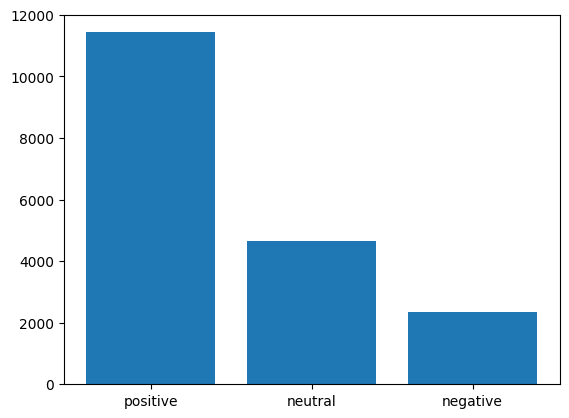

In [ ]:
plt.bar(df["Sentiment"].value_counts().index, df["Sentiment"].value_counts().values)

### Data is highly skewed toward positive, potientially create unwanted bias in model

###TODO: deal with the skewed

### For future preprocessing, the data is already processed

In [ ]:
import string
import re
from nltk.corpus import stopwords

# Download stopwords if you haven't already
import nltk
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters (keeping only alphanumeric and spaces)
    if isinstance(text, str):
        # Remove special characters (keeping only alphanumeric and spaces)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove mentions
        text = re.sub(r'@\S+', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
    # If not a string (e.g., float, NaN), return an empty string or handle it as you prefer
    else:
        text = ''  # or text = str(text) to convert it to string
    return text

# Apply the cleaning function to your comment text column
df['cleaned_comment'] = df['Comment'].apply(clean_text) # Replace 'comment_column_name'

print(df[['Comment', 'cleaned_comment']].head())


                                             Comment  \
0  lets not forget that apple pay in 2014 require...   
1  here in nz 50 of retailers don’t even have con...   
2  i will forever acknowledge this channel with t...   
3  whenever i go to a place that doesn’t take app...   
4  apple pay is so convenient secure and easy to ...   

                                     cleaned_comment  
0  lets not forget that apple pay in 2014 require...  
1  here in nz 50 of retailers dont even have cont...  
2  i will forever acknowledge this channel with t...  
3  whenever i go to a place that doesnt take appl...  
4  apple pay is so convenient secure and easy to ...  


In [ ]:
df.head()

,Comment,Sentiment,cleaned_comment
0,lets not forget that apple pay in 2014 require...,neutral,lets not forget that apple pay in 2014 require...
1,here in nz 50 of retailers don’t even have con...,negative,here in nz 50 of retailers dont even have cont...
2,i will forever acknowledge this channel with t...,positive,i will forever acknowledge this channel with t...
3,whenever i go to a place that doesn’t take app...,negative,whenever i go to a place that doesnt take appl...
4,apple pay is so convenient secure and easy to ...,positive,apple pay is so convenient secure and easy to ...


Prepare data

In [ ]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['labels'] = df['Sentiment'].map(label_map)
df = df[['cleaned_comment', 'labels']].dropna()

In [ ]:
df.head()

,cleaned_comment,labels
0,lets not forget that apple pay in 2014 require...,1
1,here in nz 50 of retailers dont even have cont...,0
2,i will forever acknowledge this channel with t...,2
3,whenever i go to a place that doesnt take appl...,0
4,apple pay is so convenient secure and easy to ...,2


labels
2    11432
1     4638
0     2338
Name: count, dtype: int64


<BarContainer object of 3 artists>

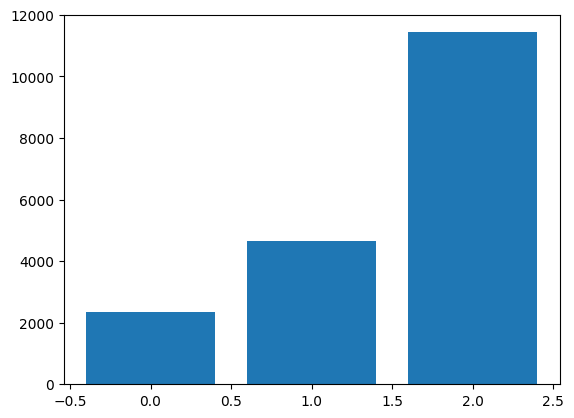

In [ ]:
print(df["labels"].value_counts())
plt.bar(df["labels"].value_counts().index, df["labels"].value_counts().values)

Tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
# Load model directly
model_name = "huawei-noah/TinyBERT_General_4L_312D"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(text):
  return tokenizer(text['text'], truncation=True, padding='max_length', max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def preprocessing(text):
  text = clean_text(text)
  text = tokenize_function(text)
  return text

Train-test split

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_comment'].tolist(), df['labels'].tolist(), test_size=0.2
)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    predictions = pred.predictions.argmax(axis=-1) # Get the predicted class labels

    # Calculate metrics using scikit-learn
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


# Model

## TinyBERT

In [ ]:
# Load the TinyBERT model (will include the embedding layers and transformer layers)
tiny_bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# Remove the original text columns
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(["text"])
# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14726 [00:00<?, ? examples/s]

Map:   0%|          | 0/3682 [00:00<?, ? examples/s]

In [ ]:

# 4. Define training arguments
training_args = TrainingArguments(
    report_to="none",
    output_dir="./tinybert_sentiment_analysis",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy = "epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# 5. Define the Trainer
tiny_bert_trainer = Trainer(
    model=tiny_bert_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer, # Pass the tokenizer as well
    compute_metrics=compute_metrics, # You'll need to define this function
)

# 6. Train the model
tiny_bert_trainer.train()

# 7. Evaluate the model
tiny_bert_trainer.evaluate()

<ipython-input-31-20019c5ac343>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tiny_bert_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.521100,0.417477,0.831342,0.816042,0.726418,0.759582
2,0.283100,0.407353,0.845193,0.803095,0.790915,0.796052
3,0.191800,0.554160,0.850896,0.814363,0.782234,0.796273
4,0.130500,0.654435,0.850625,0.805340,0.795069,0.799584
5,0.085500,0.786185,0.851983,0.816153,0.785026,0.799062
6,0.053400,0.924660,0.840304,0.799119,0.797621,0.792430
7,0.037700,0.963976,0.849810,0.803484,0.801793,0.800038
8,0.028200,0.982890,0.850625,0.810201,0.787887,0.796312
9,0.019800,1.017035,0.852526,0.812651,0.793471,0.800778
10,0.014300,1.036815,0.848995,0.807004,0.785434,0.794234


{'eval_loss': 0.4073534607887268,
 'eval_accuracy': 0.8451928299837045,
 'eval_precision': 0.8030949752272859,
 'eval_recall': 0.7909146670406679,
 'eval_f1': 0.7960517444781808,
 'eval_runtime': 13.2268,
 'eval_samples_per_second': 278.375,
 'eval_steps_per_second': 17.465,
 'epoch': 10.0}

## DistilBert

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
distil_bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 4. Define training arguments
training_args = TrainingArguments(
    report_to="none",
    output_dir="./distilbert_sentiment_analysis",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy = "epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# 5. Define the Trainer
distil_bert_trainer = Trainer(
    model=distil_bert_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer, # Pass the tokenizer as well
    compute_metrics=compute_metrics, # You'll need to define this function
)

# 6. Train the model
distil_bert_trainer.train()

# 7. Evaluate the model
distil_bert_trainer.evaluate()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-7b9fc116f32c>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distil_bert_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.529800,0.393105,0.835687,0.805413,0.747319,0.771185
2,0.275700,0.388279,0.849538,0.797236,0.796327,0.796780


{'eval_loss': 0.3882792592048645,
 'eval_accuracy': 0.8495382944052146,
 'eval_precision': 0.7972357366273978,
 'eval_recall': 0.7963270906678491,
 'eval_f1': 0.7967796222249147,
 'eval_runtime': 13.1756,
 'eval_samples_per_second': 279.455,
 'eval_steps_per_second': 17.532,
 'epoch': 2.0}

In [ ]:


# 1. Load and Preprocess Data
def load_and_preprocess_data(csv_path, sequence_length=128):  # Added sequence_length
    """
    Loads and preprocesses the sentiment analysis data.  Includes truncation.

    Args:
        csv_path (str): Path to the CSV file.
        sequence_length (int): Maximum sequence length.

    Returns:
        tuple: (train_dataloader, val_dataloader, vocab_size)
    """
    df = pd.read_csv(csv_path)
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['labels'] = df['Sentiment'].map(label_map)
    df = df[['Comment', 'labels']].dropna()

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['Comment'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42
    )

    # 2. Tokenize and Create Vocabulary
    def tokenize(text):
        return text.split()

    train_tokenized = [tokenize(text) for text in train_texts]
    val_tokenized = [tokenize(text) for text in val_texts]

    word_counts = Counter()
    for tokens in train_tokenized:
        word_counts.update(tokens)
    vocabulary = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 5]  # Simple vocab
    word_to_index = {word: index for index, word in enumerate(vocabulary)}
    vocab_size = len(vocabulary)

    def numericalize(tokens):
        # Truncate sequences
        if len(tokens) > sequence_length:
            tokens = tokens[:sequence_length]
        return [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]

    train_numericalized = [numericalize(tokens) for tokens in train_tokenized]
    val_numericalized = [numericalize(tokens) for tokens in val_tokenized]

    # 3. Pad sequences
    train_padded = pad_sequence(
        [torch.tensor(seq) for seq in train_numericalized],
        batch_first=True,
        padding_value=word_to_index['<PAD>']
    )
    val_padded = pad_sequence(
        [torch.tensor(seq) for seq in val_numericalized],
        batch_first=True,
        padding_value=word_to_index['<PAD>']
    )

    # 4. Convert to tensors and create DataLoaders
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

    train_dataset = TensorDataset(train_padded, train_labels_tensor)
    val_dataset = TensorDataset(val_padded, val_labels_tensor)

    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64)

    return train_dataloader, val_dataloader, vocab_size, word_to_index  # Return word_to_index

# 2. Define the RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)
        # embedded shape: (batch_size, seq_length, embedding_dim)
        out, _ = self.rnn(embedded)
        # out shape: (batch_size, seq_length, hidden_size)
        # We take the output of the last time step for each sequence
        out = out[:, -1, :]
        # out shape: (batch_size, hidden_size)
        out = self.fc(out)
        # out shape: (batch_size, output_size)
        return out

def train_model(model, train_dataloader, val_dataloader, epochs, learning_rate, device):
    """
    Trains the RNN model and stores metrics.

    Args:
        model (nn.Module): The RNN model.
        train_dataloader (DataLoader): DataLoader for the training data.
        val_dataloader (DataLoader): DataLoader for the validation data.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.
        device (str): 'cuda' or 'cpu'.

    Returns:
        dict: A dictionary containing the training results.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)

    results = {
        'epochs': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_f1': [],
        'val_f1': [],
        'true_labels': [],  # To store true labels for ROC AUC
        'predicted_probabilities': [],  # To store predicted probs for ROC AUC
    }

    for epoch in range(epochs):
        results['epochs'].append(epoch + 1)
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_dataloader):.4f}")

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        accuracy = accuracy_score(all_labels, all_preds)
        results['train_accuracy'].append(accuracy * 100)
        results['train_f1'].append(f1 * 100)
        print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {accuracy:.4f}, Train F1: {f1:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        val_probs = []  # Store probabilities
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                # Get probabilities for ROC AUC
                probabilities = torch.nn.functional.softmax(outputs, dim=-1)  # Get probabilities
                val_probs.extend(probabilities.cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='macro')
        accuracy = accuracy_score(val_labels, val_preds)

        results['val_accuracy'].append(accuracy * 100)
        results['val_f1'].append(f1 * 100)
        print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {val_loss / len(val_dataloader):.4f}, Val Accuracy: {accuracy:.4f}, Val F1: {f1:.4f}")
        if epoch == epochs -1 : #store only the last epoch
          results['true_labels'] = val_labels
          results['predicted_probabilities'] = val_probs

    return results
# 1. Get the data
csv_file_path = '/content/YoutubeCommentsDataSet.csv'
sequence_length = 128
train_dataloader, val_dataloader, vocab_size, word_to_index = load_and_preprocess_data(csv_file_path, sequence_length)

# 2. Train the models and get results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple RNN
rnn_model = SimpleRNN(vocab_size, 100, 256, 3)
rnn_results = train_model(rnn_model, train_dataloader, val_dataloader, 100, 0.001, device)



Epoch 1/10, Train Loss: 0.9183
Epoch 1/10, Train Accuracy: 0.6357, Train F1: 0.2858
Epoch 1/10, Val Loss: 0.8901, Val Accuracy: 0.6357, Val F1: 0.2858
Epoch 2/10, Train Loss: 0.9242
Epoch 2/10, Train Accuracy: 0.6303, Train F1: 0.2697
Epoch 2/10, Val Loss: 0.9113, Val Accuracy: 0.6303, Val F1: 0.2697
Epoch 3/10, Train Loss: 0.9183
Epoch 3/10, Train Accuracy: 0.6338, Train F1: 0.2773
Epoch 3/10, Val Loss: 0.8958, Val Accuracy: 0.6338, Val F1: 0.2773
Epoch 4/10, Train Loss: 0.9108
Epoch 4/10, Train Accuracy: 0.6357, Train F1: 0.2763
Epoch 4/10, Val Loss: 0.8974, Val Accuracy: 0.6357, Val F1: 0.2763
Epoch 5/10, Train Loss: 0.9055
Epoch 5/10, Train Accuracy: 0.6371, Train F1: 0.2810
Epoch 5/10, Val Loss: 0.8890, Val Accuracy: 0.6371, Val F1: 0.2810
Epoch 6/10, Train Loss: 0.9077
Epoch 6/10, Train Accuracy: 0.6330, Train F1: 0.2714
Epoch 6/10, Val Loss: 0.8851, Val Accuracy: 0.6330, Val F1: 0.2714
Epoch 7/10, Train Loss: 0.9081
Epoch 7/10, Train Accuracy: 0.6354, Train F1: 0.2791
Epoch 7/10

In [ ]:
#get rnn final accuracy, precision, recall, f1-score

import numpy as np
# Extract final metrics for RNN
final_rnn_accuracy = rnn_results['val_accuracy'][-1] / 100
final_rnn_f1 = rnn_results['val_f1'][-1] / 100

# Calculate final precision and recall for RNN
from sklearn.metrics import precision_score, recall_score

# Need the actual predictions and true labels for the last epoch
# We stored val_labels in rnn_results['true_labels']
true_labels_rnn = rnn_results['true_labels']
predicted_probabilities_rnn = np.array(rnn_results['predicted_probabilities'])
predicted_labels_rnn = np.argmax(predicted_probabilities_rnn, axis=1)

final_rnn_precision = precision_score(true_labels_rnn, predicted_labels_rnn, average='macro')
final_rnn_recall = recall_score(true_labels_rnn, predicted_labels_rnn, average='macro')


print(f"Final RNN Accuracy: {final_rnn_accuracy:.4f}")
print(f"Final RNN Precision: {final_rnn_precision:.4f}")
print(f"Final RNN Recall: {final_rnn_recall:.4f}")
print(f"Final RNN F1-score: {final_rnn_f1:.4f}")

Final RNN Accuracy: 0.6338
Final RNN Precision: 0.4855
Final RNN Recall: 0.3384
Final RNN F1-score: 0.2702


In [ ]:
def get_trainer_results(trainer, val_dataset, model, tokenizer): # Changed from val_dataloader to val_dataset
    """
    Evaluates a trained Hugging Face Trainer model and returns the evaluation metrics.

    Args:
        trainer (Trainer): The trained Hugging Face Trainer object.
        val_dataset (Dataset): Hugging Face Dataset for the validation set. # Changed from val_dataloader
        model (PreTrainedModel): The trained model.
        tokenizer (PreTrainedTokenizer): The tokenizer used with the model.

    Returns:
        dict: A dictionary containing the evaluation metrics (accuracy, precision, recall, f1-score).
    """
    # Using trainer.get_eval_dataloader() is the recommended way to get a DataLoader
    # for evaluation when using a Trainer, as it handles batching and device placement.
    val_dataloader = trainer.get_eval_dataloader(val_dataset) # Get dataloader from dataset

    device = trainer.model.device
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            # Explicitly remove 'token_type_ids' if it exists in the batch
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels' and k != 'token_type_ids'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits  # Get the logits from the output
            predictions = torch.argmax(logits, dim=-1)  # Get the predicted class labels
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics using scikit-learn
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    accuracy = accuracy_score(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Call the updated function with the datasets used by the Trainer
tinybert_results = get_trainer_results(tiny_bert_trainer, tokenized_val_dataset, tiny_bert_model, tokenizer)
distilbert_results = get_trainer_results(distil_bert_trainer, tokenized_val_dataset, distil_bert_model, tokenizer)

In [ ]:
all_results = {
    'TinyBERT': tinybert_results,
    'DistilBERT': distilbert_results
}

# 4. Print the results
for model_name, result in all_results.items():
    print(f"Results for {model_name}:")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall:    {result['recall']:.4f}")
    print(f"  F1-Score:  {result['f1']:.4f}")
    print()
print(f"Results for RNN:")
print(f"  Accuracy: {final_rnn_accuracy:.4f}")
print(f"  Precision: {final_rnn_precision:.4f}")
print(f"  Recall: {final_rnn_recall:.4f}")
print(f"  F1-score: {final_rnn_f1:.4f}")

Results for TinyBERT:
  Accuracy: 0.8452
  Precision: 0.8031
  Recall:    0.7909
  F1-Score:  0.7961

Results for DistilBERT:
  Accuracy: 0.8495
  Precision: 0.7972
  Recall:    0.7963
  F1-Score:  0.7968

Results for RNN:
  Accuracy: 0.6338
  Precision: 0.4855
  Recall: 0.3384
  F1-score: 0.2702


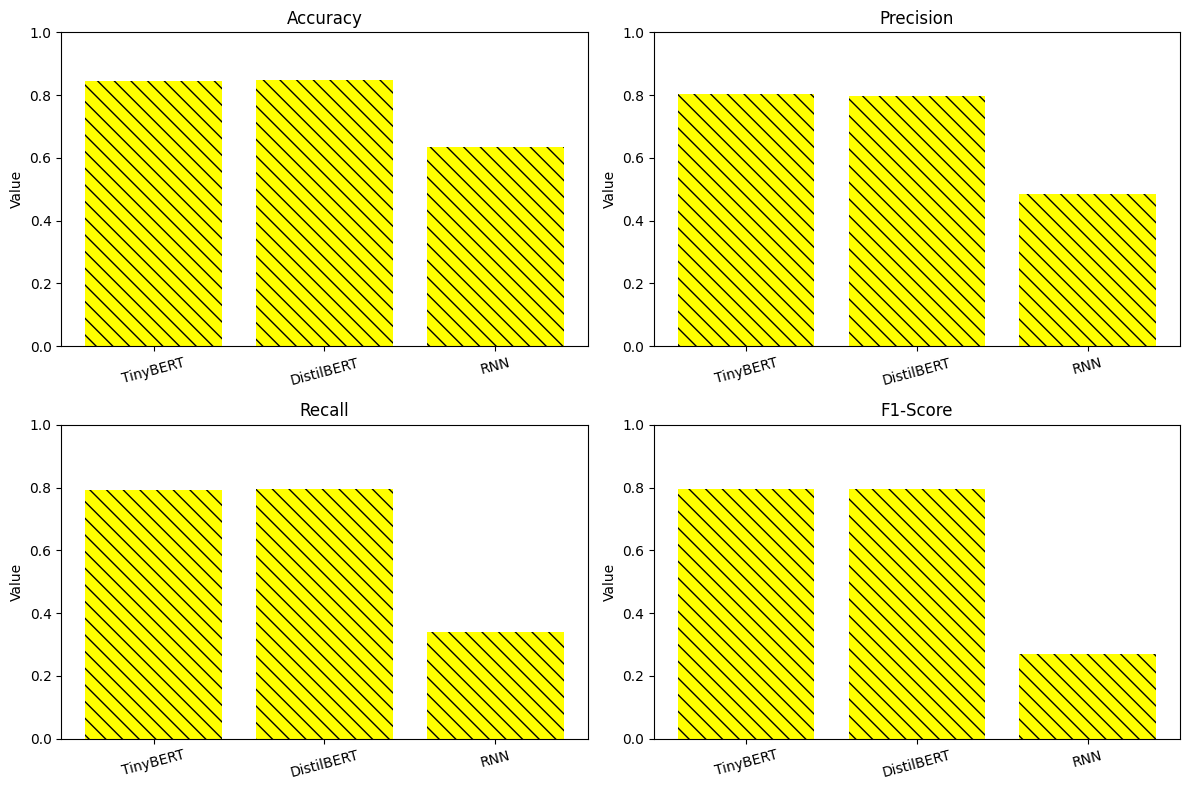

In [ ]:
names = ['TinyBERT', 'DistilBERT', 'RNN']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
accuracy_vec = {}
precision_vec = {}
recall_vec = {}
f1_score_vec = {}
vecs = [accuracy_vec, precision_vec, recall_vec, f1_score_vec]

# Load data from the provided results
tinybert_results = {
    'accuracy': 0.8452,
    'precision': 0.8031,
    'recall': 0.7909,
    'f1': 0.7961
}

distilbert_results = {
    'accuracy': 0.8495,
    'precision': 0.7972,
    'recall': 0.7963,
    'f1': 0.7968
}

rnn_results = {
    'accuracy': 0.6338,
    'precision': 0.4855,
    'recall': 0.3384,
    'f1': 0.2702
}

all_results = {
    'TinyBERT': tinybert_results,
    'DistilBERT': distilbert_results,
    'RNN': rnn_results,
}

for name, result in all_results.items():
    accuracy_vec[name] = result['accuracy']
    precision_vec[name] = result['precision']
    recall_vec[name] = result['recall']
    f1_score_vec[name] = result['f1']

plt.figure(figsize=(12, 8))
for i in range(len(vecs)):
    plt.subplot(2, 2, i + 1)
    plt.bar(vecs[i].keys(), vecs[i].values(), color='yellow', hatch='\\\\')
    plt.title(metrics[i])
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()